# Objective

We will investigate the data

# Import libraries, paths and tools

In [15]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score,precision_score, recall_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import RocCurveDisplay
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import os
import random
pd.options.display.float_format = '{:.2f}'.format

In [16]:
#data repository

data_dir = Path(r'/Users/michaelargi/projects/perso/unsupervised/ML_Export_20_03')
folder_path = data_dir
rl_folder_path = os.path.join(data_dir, 'ML_Export_rlv')

data_paths = {
    'combined_data':'combined_data.csv',
    'combined_data_agregatedInstallation':'combined_data_installation.csv',
    'anomalies':'Ano_Dataset_reduit_Nov2022_Fev2024.csv',
    'combined_data_Adjusted_Index_Change':'consolidated_with_Adjusted_Index_Change.csv',
    'train':'train.csv',
    'test':'test.csv',
    'validation':'validation.csv',
    'cleaned':'tmp/data_cleaned.csv',
    'ready':'tmp/data_ready.csv',
    'X_train':'tmp/train_features.csv',
    'y_train':'tmp/train_target.csv',
    'X_val':'tmp/val_features.csv',
    'y_val':'tmp/val_target.csv',
    'X_train_processed':'tmp/train_features_processed.csv',
    'X_val_processed':'tmp/val_features_processed.csv',
    'check':'tmp/check.csv',
    'dayoffs':'DAY_OFFS.csv'
}



In [17]:
class Environment:
    target_column_name = "Releve"
    should_rename_columns= False
    should_bin=False
    num_bins = 5
    nb_binning_limit = 20
    binned_suffix = "_BINNED"
    show_graphs = False
    should_normalize = False
    final_normalization= False
    def todict(self):
      return{
          "target_column_name":self.target_column_name,
          "should_rename_columns":self.should_rename_columns,
          "should_bin":self.should_bin,
          "num_bins":self.num_bins,
          "nb_binning_limit": self.nb_binning_limit,
          "binned_suffix" :self.binned_suffix,
          "show_graphs" :self.show_graphs,
          "should_normalize" :self.should_normalize,
          "final_normalization": self.final_normalization
      }


ENV= Environment()


In [18]:
import csv,json
from datetime import datetime

def create_result_folder():
  prefix="results_"
  now = datetime.now()
  time_str = now.strftime("%Y%m%d_%H%M%S")
  folder_name = f"{prefix}{time_str}"
  folder_path = os.path.join(data_dir, folder_name)
  os.mkdir(folder_path)
  return folder_path

#folder_path=create_result_folder()

#save dict in file
def saveDictInFile(dict, file_name):
    print("saveDictInFile")
    os.makedirs(folder_path, exist_ok=True)
    csv_file_path = os.path.join(folder_path, file_name)
    with open(csv_file_path, "w", newline="") as fp:
      writer = csv.DictWriter(fp, fieldnames=dict.keys())
      writer.writeheader()
      writer.writerow(dict)

#save list in file
def write_list(a_list,file_name):
  csv_file_path = os.path.join(folder_path, file_name)
  df = pd.DataFrame(a_list)
  dataframe_to_csv(df,csv_file_path)

#Save dataframe to csv
def dataframe_to_csv(df,file_name):
  csv_file_path = os.path.join(folder_path, file_name)
  df.to_csv(csv_file_path, index=False)

def generate_name_based_on_time(prefix="Name_", suffix=""):
    now = datetime.now()
    time_str = now.strftime("%Y%m%d_%H%M%S")
    name = f"{prefix}{time_str}{suffix}"
    return name

saveDictInFile(ENV.todict(),"env.csv")

#result_file_name = "results.csv"

saveDictInFile


In [19]:
#utils
def encode_columns(data_frame, verbose=False):
  #Encoding
  label_encoder = LabelEncoder()
  for column in data_frame.columns:
      if column == ENV.target_column_name:
        data_frame[ENV.target_column_name] = data_frame[ENV.target_column_name].astype(int)
        if verbose:
          print("Don't encode target, we convert to int")
        continue
      if data_frame[column].dtype == 'object':  # Check if the column is of type 'object' (string)
          data_frame[column] = label_encoder.fit_transform(data_frame[column])
      elif data_frame[column].dtype == 'bool':
          data_frame[column].replace({True: 1, False: 0},inplace=True)
      else:
        if verbose:
          print("encode_columns error "+column+" ")
        #print(data_frame[column].dtype)


def drop_columns(data_frame,columns_to_drop,verbose=False):
  data_frame_copy = data_frame.copy()
  for column in columns_to_drop:
    if column in data_frame_copy.columns:
        if verbose:
            print("dropping column")
        data_frame_copy.drop(columns=column, inplace=True)
    else:
        if verbose:
            print(f"Column '{column}' does not exist in the DataFrame.")
  return data_frame_copy

In [20]:
def is_key_column(col):
  nb_unique_values = col.nunique()
  return nb_unique_values>100 and  nb_unique_values/col.count()>0.7

def is_binnable(col,nb_bins):
  nb_unique_values = col.nunique()
  return nb_unique_values>nb_bins and nb_unique_values> ENV.nb_binning_limit

def normalize(df:pd.DataFrame, col_name:str, factor):
  min = df[col_name].min()
  max = df[col_name].max()
  df[col_name]=(df[col_name]-min)/(max - min) * factor

#Clear folder's content, delete all file inside
def clear_folder(folder_path):
  files = os.listdir(folder_path)
  for file in files:
      file_path = os.path.join(folder_path, file)
      if os.path.isfile(file_path):
          os.remove(file_path)



In [21]:
#binning
from sklearn.tree import DecisionTreeRegressor

def create_bin_column(df:pd.DataFrame,column:str,num_bins:int, optional_bin_edges = None, verbose = False):
  if column == ENV.target_column_name:
    return

  if verbose:
    print("binning "+column)
  col = df[column]
  target_column_name= ENV.target_column_name
  target = df[target_column_name]
  if verbose:
    print("min",col.min())
    print("max",col.max())
  if col.nunique() <= num_bins:
    if verbose:
      print("too few for binning, returning")
    return
  if(optional_bin_edges):
    bin_edges = optional_bin_edges
  else:
    nb_leaves= num_bins
    tree = DecisionTreeRegressor(max_leaf_nodes=nb_leaves )
    tree.fit(df[[column]], target)

    # Use the decision tree to assign each data point to a bin
    bin_edges = tree.tree_.threshold[tree.tree_.feature != -2]

    # You might want to add the minimum and maximum edges
    bin_edges = np.concatenate(([col.min()], bin_edges, [col.max()]))
    if verbose:
      print(bin_edges)

    # Sort the array to ensure correct order of bin edges
    bin_edges.sort()

  # Print bin edges
  if verbose:
    print("Bin edges:", bin_edges)

  df[column + ENV.binned_suffix] = pd.cut(df[column], bins=bin_edges, include_lowest=True, labels=range(num_bins))

  return bin_edges


In [22]:
def transform_column_name(name):
    # Remove trailing spaces, replace special characters with underscores, and convert to capital letters
    return name.strip().replace(' ', '_').replace('@', '_').upper()

In [39]:
def show_unique_values(df, column_name):
    ps_type=df[column_name].dtype
    print("-"*20)
    print(f"show_unique_values of {column_name} which is {ps_type}")
    df_sorted = df.sort_values(by=column_name)
    unique_values_counts = df_sorted[column_name].value_counts().sort_index()
    print(unique_values_counts)
    na_counts = df_sorted[column_name].isna().sum()
    print(f'na_counts={na_counts}')

# Function to get specific data and format if needed

In [23]:
def get_combined_df(regenerate = False):
    print("get_combined_df")
    export_path = os.path.join(folder_path,data_paths['combined_data'])
    columns_to_drop=['Unitee']
    
    def set_column_to_number(df, column_name,type):
        df[column_name] = df[column_name].str.replace('.', '').str.replace(',', '.', regex=False).str.replace(' ', '', regex=False).astype(float)
        df[column_name] = df[column_name].astype(type)
    
    def transform_Puissance_souscrite_value(value):
        value_str = str(value)
        retour = value_str
        if ',' in value_str:
            # Split on ',' and keep the left part
            left_part = value_str.split(',')[0]
            # Remove '.' from the left part
            retour = left_part.replace('.', '')
        elif value is None:  # Handle None values explicitly if necessary
            retour = "0"

        try:
            # Try converting retour to float
            float(retour)
        except ValueError:
            # If conversion fails, print the value and optionally, you can handle it
            print(f'"{retour}" cannot be converted to float')
            retour = "Impossible"  # Set to "Impossible" or any indicative string
        return retour
    
    def export_releves():
        column_name_mapping = {
            'ABLBELNR': 'Releve',
            'GERNR': 'Appareil',
            'EQUNR': 'Equipement',
            'ZWNUMMER': 'Cadran',
            'ADAT': 'Date_de_releve',
            'V_ZWSTAND': 'Index',
            'MASSREAD': 'Unitee',
            'ANLAGE': 'Installation',
            'REGIOGROUP': 'Region',
            'IND_SECTOR': 'Code_Naf',
            'NumANO':'Anomalie',
            'Num_rlv':'Releve',
            "Datedel'ano":'Date_de_anomalie',
            'PRM':'Installation',
            'Cadran':'Cadran',
            'Datedelarlv':'Date_de_releve',
            'INDEX':'Index',
            'Num_rlv':'Releve',
            'NumCadran':'Cadran',
            'Datederlv':'Date_de_releve',
            'INDEX':'Index',
            'Régiion':'Région',
            'IND_SECTOR':'Code_Naf',
            'Typedecadran':'Type_cadran',
            'PuissanceSouscrite':'Puissance_souscrite'
        }
        
        dtype = {'MASSREAD':str,'Régiion': str, 'IND_SECTOR': str,'INDEX':str,'Conso':str,'Puissance Souscrite':str,'Type de cadran':str}
        data_frames = []
        print(folder_path)
        for filename in os.listdir(rl_folder_path):
            if filename.endswith('.csv'):
                print("adding "+filename)
                file_path = os.path.join(rl_folder_path, filename)
                df = pd.read_csv(file_path,dtype=dtype,encoding='utf-8',low_memory=False)
                #for column in df.columns:
                #    print(f'"{column}"')
                #print(df.dtypes)
                #df=df.head(1)
                #print(df.columns)
                #print(df.head())
                df.columns = df.columns.str.replace(' ', '', regex=False)
                df = drop_columns(df,columns_to_drop)
                if set(column_name_mapping.keys()).intersection(df.columns):
                    df.rename(columns=column_name_mapping, inplace=True)
                #na_counts_before = df['Puissance_souscrite'].isna().sum()
                set_column_to_number(df,'Conso','int')
                set_column_to_number(df,'Index','int')
                df['Puissance_souscrite'] = df['Puissance_souscrite'].str.replace(' ', '', regex=False)
                df['Date_de_releve']=pd.to_datetime(df['Date_de_releve'], format='%Y%m%d')
                data_frames.append(df)
                _combined_df = pd.concat(data_frames, ignore_index=True)
        _combined_df['Cadran_key'] = _combined_df['Installation'].astype(str) + "_" + _combined_df['Cadran'].astype(str)
        #now that combined let's modify
        is_numeric = pd.api.types.is_numeric_dtype(_combined_df['Puissance_souscrite'])
        print(f'is_numeric ={is_numeric}')
        if not is_numeric:
            chunk_size = 50000
            chunks = [x for x in range(0, _combined_df.shape[0], chunk_size)]
            # Initialize an empty DataFrame to hold the processed chunks
            processed_df = pd.DataFrame()
            for start in chunks:
                end = start + chunk_size
                # Slice the DataFrame to get the current chunk
                chunk = _combined_df.iloc[start:end]
                # Apply the transformation
                chunk['Puissance_souscrite'] = chunk['Puissance_souscrite'].apply(transform_Puissance_souscrite_value)
                # Append the processed chunk to the processed_df DataFrame
                processed_df = pd.concat([processed_df, chunk], axis=0)

            # Now, processed_df contains the entire DataFrame with the transformations applied in batches
            _combined_df = processed_df
            _combined_df['Puissance_souscrite'] = pd.to_numeric(_combined_df['Puissance_souscrite'], downcast='integer', errors='raise')
        dataframe_to_csv(_combined_df,data_paths['combined_data'])
        return _combined_df
        
    if os.path.isfile(export_path) and not regenerate:
        combined_df = pd.read_csv(export_path,dtype=dtype_spec,low_memory=False)
        combined_df = drop_columns(combined_df,columns_to_drop)
        combined_df['Puissance_souscrite'].to_csv('Puissance_souscrite.csv', index=False)
        combined_df['Date_de_releve'].to_csv('Date_de_releve.csv', index=False)
    else:
        combined_df = export_releves()
    try:
        combined_df['Date_de_releve'] = pd.to_datetime(combined_df['Date_de_releve'], format='%Y%m%d')
    except:
        combined_df['Date_de_releve'] = pd.to_datetime(combined_df['Date_de_releve'], format='%Y-%m-%d')
    combined_df.sort_values(by=['Installation','Cadran', 'Date_de_releve'], inplace=True)
    return combined_df

releves_df = get_combined_df()

print(releves_df.columns)
print(releves_df.dtypes)


getting
/Users/michaelargi/projects/perso/unsupervised/ML_Export_20_03
adding RLV_Dataset_reduit_23_09.csv


/var/folders/7v/cgc6db_s0jg20l4ckkkc8s7w0000gn/T/ipykernel_51400/3768290546.py:8: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  df[column_name] = df[column_name].str.replace('.', '').str.replace(',', '.', regex=False).str.replace(' ', '', regex=False).astype(float)


adding RLV_Dataset_reduit_24_01.csv


/var/folders/7v/cgc6db_s0jg20l4ckkkc8s7w0000gn/T/ipykernel_51400/3768290546.py:8: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  df[column_name] = df[column_name].str.replace('.', '').str.replace(',', '.', regex=False).str.replace(' ', '', regex=False).astype(float)


adding RLV_Dataset_reduit_23_08.csv


/var/folders/7v/cgc6db_s0jg20l4ckkkc8s7w0000gn/T/ipykernel_51400/3768290546.py:8: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  df[column_name] = df[column_name].str.replace('.', '').str.replace(',', '.', regex=False).str.replace(' ', '', regex=False).astype(float)


adding RLV_Dataset_reduit_24_02.csv


/var/folders/7v/cgc6db_s0jg20l4ckkkc8s7w0000gn/T/ipykernel_51400/3768290546.py:8: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  df[column_name] = df[column_name].str.replace('.', '').str.replace(',', '.', regex=False).str.replace(' ', '', regex=False).astype(float)


adding RLV_Dataset_reduit_22_11.csv


/var/folders/7v/cgc6db_s0jg20l4ckkkc8s7w0000gn/T/ipykernel_51400/3768290546.py:8: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  df[column_name] = df[column_name].str.replace('.', '').str.replace(',', '.', regex=False).str.replace(' ', '', regex=False).astype(float)


adding RLV_Dataset_reduit_22_12.csv


/var/folders/7v/cgc6db_s0jg20l4ckkkc8s7w0000gn/T/ipykernel_51400/3768290546.py:8: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  df[column_name] = df[column_name].str.replace('.', '').str.replace(',', '.', regex=False).str.replace(' ', '', regex=False).astype(float)


adding RLV_Dataset_reduit_23_01.csv


/var/folders/7v/cgc6db_s0jg20l4ckkkc8s7w0000gn/T/ipykernel_51400/3768290546.py:8: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  df[column_name] = df[column_name].str.replace('.', '').str.replace(',', '.', regex=False).str.replace(' ', '', regex=False).astype(float)


adding RLV_Dataset_reduit_23_03.csv


/var/folders/7v/cgc6db_s0jg20l4ckkkc8s7w0000gn/T/ipykernel_51400/3768290546.py:8: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  df[column_name] = df[column_name].str.replace('.', '').str.replace(',', '.', regex=False).str.replace(' ', '', regex=False).astype(float)


adding RLV_Dataset_reduit_23_02.csv


/var/folders/7v/cgc6db_s0jg20l4ckkkc8s7w0000gn/T/ipykernel_51400/3768290546.py:8: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  df[column_name] = df[column_name].str.replace('.', '').str.replace(',', '.', regex=False).str.replace(' ', '', regex=False).astype(float)


adding RLV_Dataset_reduit_23_06.csv


/var/folders/7v/cgc6db_s0jg20l4ckkkc8s7w0000gn/T/ipykernel_51400/3768290546.py:8: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  df[column_name] = df[column_name].str.replace('.', '').str.replace(',', '.', regex=False).str.replace(' ', '', regex=False).astype(float)


adding RLV_Dataset_reduit_23_12.csv


/var/folders/7v/cgc6db_s0jg20l4ckkkc8s7w0000gn/T/ipykernel_51400/3768290546.py:8: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  df[column_name] = df[column_name].str.replace('.', '').str.replace(',', '.', regex=False).str.replace(' ', '', regex=False).astype(float)


adding RLV_Dataset_reduit_23_07.csv


/var/folders/7v/cgc6db_s0jg20l4ckkkc8s7w0000gn/T/ipykernel_51400/3768290546.py:8: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  df[column_name] = df[column_name].str.replace('.', '').str.replace(',', '.', regex=False).str.replace(' ', '', regex=False).astype(float)


adding RLV_Dataset_reduit_23_11.csv


/var/folders/7v/cgc6db_s0jg20l4ckkkc8s7w0000gn/T/ipykernel_51400/3768290546.py:8: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  df[column_name] = df[column_name].str.replace('.', '').str.replace(',', '.', regex=False).str.replace(' ', '', regex=False).astype(float)


adding RLV_Dataset_reduit_23_05.csv


/var/folders/7v/cgc6db_s0jg20l4ckkkc8s7w0000gn/T/ipykernel_51400/3768290546.py:8: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  df[column_name] = df[column_name].str.replace('.', '').str.replace(',', '.', regex=False).str.replace(' ', '', regex=False).astype(float)


adding RLV_Dataset_reduit_23_04.csv


/var/folders/7v/cgc6db_s0jg20l4ckkkc8s7w0000gn/T/ipykernel_51400/3768290546.py:8: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  df[column_name] = df[column_name].str.replace('.', '').str.replace(',', '.', regex=False).str.replace(' ', '', regex=False).astype(float)


adding RLV_Dataset_reduit_23_10.csv


/var/folders/7v/cgc6db_s0jg20l4ckkkc8s7w0000gn/T/ipykernel_51400/3768290546.py:8: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  df[column_name] = df[column_name].str.replace('.', '').str.replace(',', '.', regex=False).str.replace(' ', '', regex=False).astype(float)


is_numeric =False


/var/folders/7v/cgc6db_s0jg20l4ckkkc8s7w0000gn/T/ipykernel_51400/3768290546.py:99: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chunk['Puissance_souscrite'] = chunk['Puissance_souscrite'].apply(transform_Puissance_souscrite_value)


Empty DataFrame
Columns: [Releve, Appareil, Equipement, Cadran, Date_de_releve, Index, Unitee, Installation, Région, Code_Naf, Puissance_souscrite, ABLESGR, Type_cadran, Conso, Cadran_key]
Index: []
Index(['Releve', 'Appareil', 'Equipement', 'Cadran', 'Date_de_releve', 'Index',
       'Unitee', 'Installation', 'Région', 'Code_Naf', 'Puissance_souscrite',
       'ABLESGR', 'Type_cadran', 'Conso', 'Cadran_key'],
      dtype='object')
Releve                          int64
Appareil                        int64
Equipement                      int64
Cadran                          int64
Date_de_releve         datetime64[ns]
Index                           int64
Unitee                         object
Installation                    int64
Région                         object
Code_Naf                       object
Puissance_souscrite           float64
ABLESGR                         int64
Type_cadran                    object
Conso                           int64
Cadran_key                     o

In [25]:
def get_anomalies():
    dtype_spec = {'IDPtLvrsn': str}
    column_name_mapping={
        'numano': 'Num_ano',
        'Numeroderlv':'Releve', 
        'Dateano':'Date_de_anomalie', 
        'PRM':'PRM', 
        'Datederlv':'Date_de_releve'
    }
    anomalies_path = os.path.join(data_dir, data_paths['anomalies'])
    print('anomalies_path',anomalies_path)
    columns_to_drop=['ConsCli.','Cdeachat']
    anomalies_df = pd.read_csv(anomalies_path,dtype=dtype_spec,low_memory=False)
    anomalies_df.columns = anomalies_df.columns.str.replace(' ', '', regex=False)
    
    if set(column_name_mapping.keys()).intersection(anomalies_df.columns):
        anomalies_df.rename(columns=column_name_mapping, inplace=True)
        
    anomalies_df['Date_de_anomalie'] = pd.to_datetime(anomalies_df['Date_de_anomalie'], format='%Y%m%d')
    anomalies_df['Date_de_releve'] = pd.to_datetime(anomalies_df['Date_de_releve'], format='%Y%m%d')
    
    anomalies_df = drop_columns(anomalies_df,columns_to_drop)
    print(anomalies_df.columns)
    return anomalies_df



anomalies_df=get_anomalies()


anomalies_path /Users/michaelargi/projects/perso/unsupervised/ML_Export_20_03/Ano_Dataset_reduit_Nov2022_Fev2024.csv
Index(['Num_ano', 'Releve', 'Date_de_anomalie', 'PRM', 'Cadran',
       'Date_de_releve', 'Index'],
      dtype='object')


In [26]:

def get_aggregated_data():
    print('get_aggregated_data => per Installation')
    path = os.path.join(folder_path,data_paths['combined_data_agregatedInstallation'])
    print(path)
    isFile = os.path.isfile(path) 
    if isFile:
        aggregated_data = pd.read_csv(path)
    else:
        print("aggregating")
        aggregated_data = releves_df.groupby(['Installation', 'Date_de_releve']).agg(
            AggregatedIndex=pd.NamedAgg(column='Index', aggfunc='sum'),
            nbCadrans=pd.NamedAgg(column='Cadran', aggfunc=lambda x: x.nunique())
        ).reset_index()
        print("exporting")
        dataframe_to_csv(aggregated_data,data_paths['combined_data_agregatedInstallation'])
    return aggregated_data

aggregated_data = get_aggregated_data()
print(aggregated_data.columns)


get_aggregated_data => per Installation
/Users/michaelargi/projects/perso/unsupervised/ML_Export_20_03/combined_data_installation.csv
aggregating
exporting
Index(['Installation', 'Date_de_releve', 'AggregatedIndex', 'nbCadrans'], dtype='object')


In [27]:
def add_change_column(df):
    print("started")
    df.sort_values(by=['Cadran_key', 'Date_de_releve'], inplace=True)

    # Calculate the difference in days between successive Date_de_releve entries
    df['Time_diff'] = df.groupby('Cadran_key')['Date_de_releve'].diff().dt.days

    df['Index_change'] = df.groupby('Cadran_key')['Index'].diff()
    # Calculate the percentage change of the Index
    df['Index_pct_change'] = df.groupby('Cadran_key')['Index'].pct_change() * 100

    # Adjust the Index Percentage Change by the Time Difference
    df['Adjusted_Index_Change'] = df['Index_pct_change'] / df['Time_diff']
    return df

def get_aggregated_data_with_Adjusted_Index_Change():
    print('get_aggregated_data_with_Adjusted_Index_Change')
    path = os.path.join(folder_path,data_paths['combined_data_Adjusted_Index_Change'])
    print(path)
    isFile = os.path.isfile(path) 
    if isFile:
        aggregated_data = pd.read_csv(path)
    else:
        print("aggregating")
        aggregated_data = add_change_column(releves_df)
        dataframe_to_csv(aggregated_data,data_paths['combined_data_Adjusted_Index_Change'])
        print("produced")
    return aggregated_data

#wazza = get_aggregated_data_with_Adjusted_Index_Change()

In [28]:
def get_releve_info(df, releve):
    filtered_rows = df[df['Releve'] == releve]
    return filtered_rows

# Display data info and Check consistency

Show general info about data

Matching anomalies and releves



In [29]:
def plot_index_per_date_for_appareil(df, appareil):
    # Filter DataFrame based on the 'Appareil' value
   
    filtered_df = df[df['Appareil'] == appareil]
    
    # Get unique 'Cadran' values
    cadran_values = filtered_df['Cadran'].unique()
    
    plt.figure(figsize=(12, 8))  # Adjust figure size as needed
    
    # Loop through each 'Cadran' value and plot
    for cadran in cadran_values:
        subset_df = filtered_df[filtered_df['Cadran'] == cadran]
        plt.plot(subset_df['Date_de_releve'], subset_df['Index'], marker='o', label=f'Cadran {cadran}')
    
    plt.title(f'Index per Date for Appareil: {appareil}')
    plt.xlabel('Date de Releve')
    plt.ylabel('Index')
    plt.legend()
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


#plot_index_per_date_for_appareil(consolidated_df,10000007016)

def plot_index_per_date_for_installation(df, installation,saveName=""):
    plot_value_per_date_for_installation(df,installation,'Index',saveName)

def plot_value_per_date_for_installation(df, installation,column,saveName=""):
    filtered_df = df[df['Installation'] == installation]
    # Get unique 'Cadran' values
    cadran_values = filtered_df['Cadran'].unique()
    plt.figure(figsize=(12, 8))  # Adjust figure size as needed
    # Loop through each 'Cadran' value and plot
    for cadran in cadran_values:
        subset_df = filtered_df[filtered_df['Cadran'] == cadran]
        plt.plot(subset_df['Date_de_releve'], subset_df[column], marker='o', label=f'Cadran {cadran}')
    
    plt.title(f'{column} per Date for Installation: {installation}')
    plt.xlabel('Date de Releve')
    plt.ylabel(column)
    plt.legend()
    plt.xticks(rotation=45)
    plt.tight_layout()
    if saveName:
        plt.savefig(saveName)
        plt.close()
    else:
        plt.show()


#plot_index_per_date_for_installation(consolidated_df,292561)

def plot_index_per_date_for_Cadran(df, cadran_key):
    cadran_key = str(cadran_key)
    specific_cadran_df = df[df['Cadran_key'] == cadran_key]
    plt.figure(figsize=(10, 6))
    plt.plot(specific_cadran_df['Date_de_releve'], specific_cadran_df['Index'], marker='o')
    plt.title(f'Index vs Date_de_releve for Cadran_key {cadran_key}')
    plt.xlabel('Date_de_releve')
    plt.ylabel('Index')
    plt.xticks(rotation=45)  # Rotate dates for better readability
    plt.tight_layout()
    plt.show()
    
#plot_index_per_date_for_Cadran(consolidated_df,'41036885728_1')
    


def print_Date_de_Releve_for_Cadran_key(df, specific_cadran_key):
    filtered_df = df[df['Cadran_key'] == specific_cadran_key]
    print(filtered_df['Date_de_releve'])
    
#print_Date_de_Releve_for_Cadran_key(consolidated_df,'41036856101_1')


    


Check Releves matching
Anomalie Releve not found in releves references :3814579295 from 7631529 with date 2023-01-23 00:00:00
nb Found Anomalie releves in 100 releves: 99
removing first occurence of Date_de_releve
And I check again against 100 first anomalies
Check Releves matching
Anomalie Releve not found in releves references :3814579295 from 7631529 with date 2023-01-23 00:00:00
Anomalie Releve not found in releves references :4293211805 from 8131353 with date 2023-12-23 00:00:00
nb Found Anomalie releves in 100 releves: 98
nb anomalies not found 2 in 100 after removing first occurence of Date_de_releve in releves 
['7631529', '8131353']
********************
Installation graphs
********************
[('7671851', Timestamp('2023-02-11 00:00:00'), 1)]


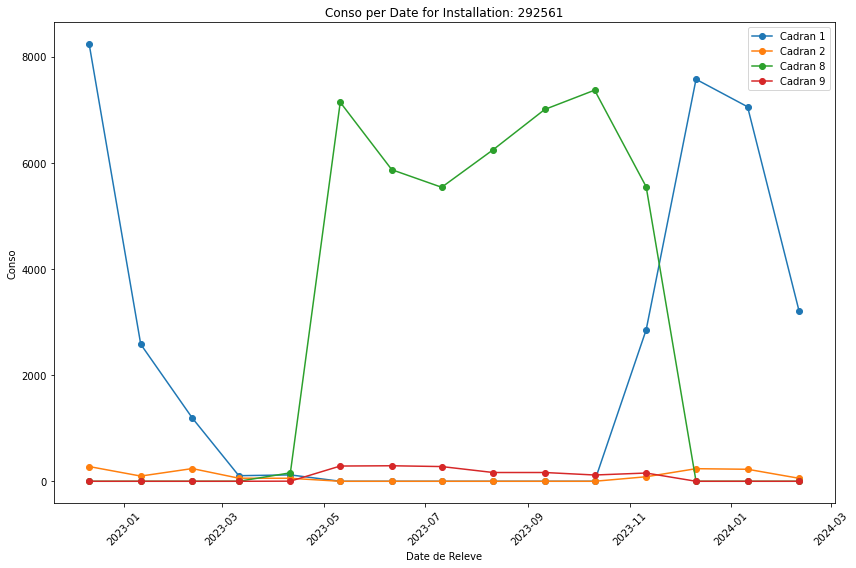

[('7815922', Timestamp('2023-05-18 00:00:00'), 9), ('7859984', Timestamp('2023-06-17 00:00:00'), 9), ('7903216', Timestamp('2023-07-18 00:00:00'), 9), ('7946332', Timestamp('2023-08-18 00:00:00'), 9), ('7988586', Timestamp('2023-09-17 00:00:00'), 9), ('8126518', Timestamp('2023-12-18 00:00:00'), 2), ('8258450', Timestamp('2024-02-16 00:00:00'), 2)]


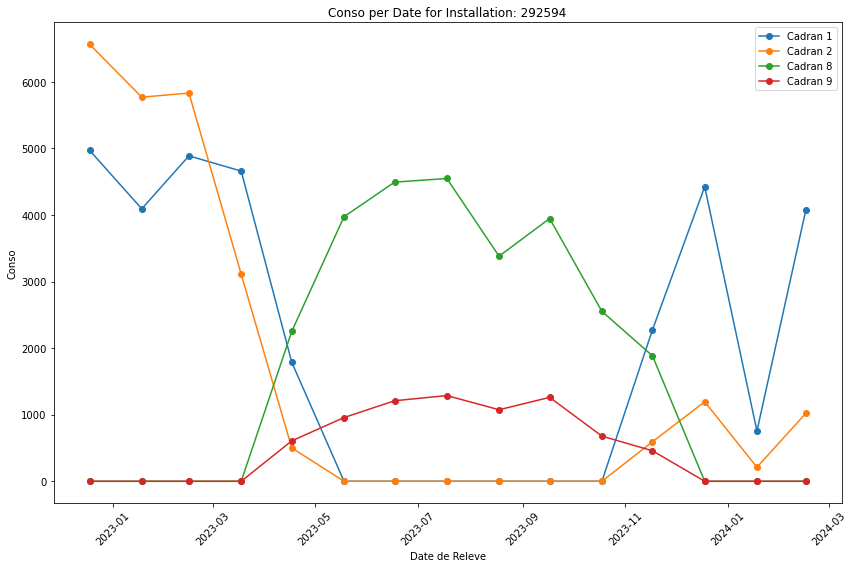

[('7810635', Timestamp('2023-05-13 00:00:00'), 8)]


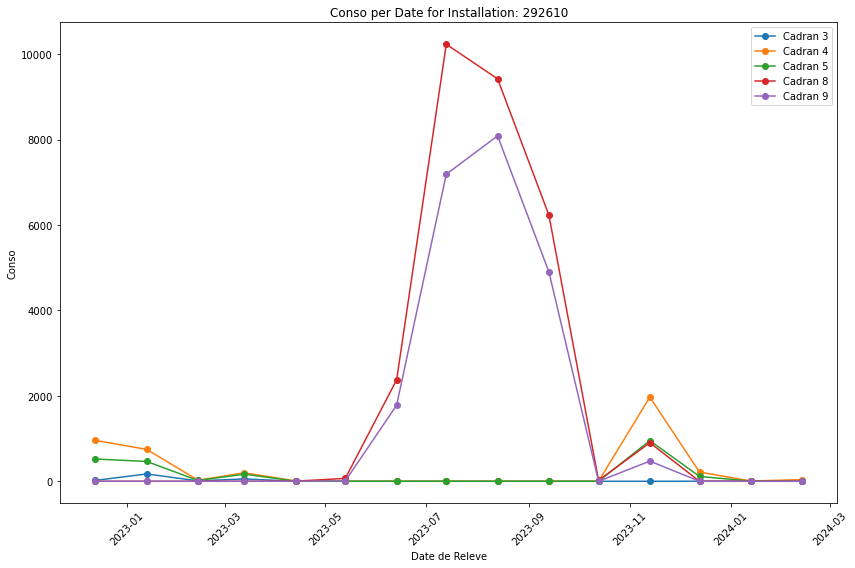

[('8125142', Timestamp('2023-12-17 00:00:00'), 1), ('8125121', Timestamp('2023-12-17 00:00:00'), 2), ('8203719', Timestamp('2024-01-17 00:00:00'), 1), ('8257142', Timestamp('2024-02-15 00:00:00'), 1), ('8257143', Timestamp('2024-02-15 00:00:00'), 2)]


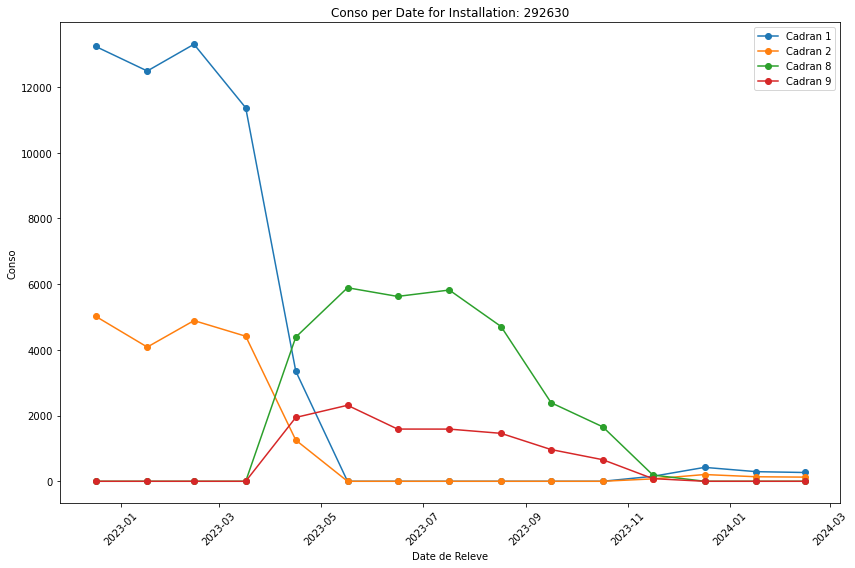

[('7859255', Timestamp('2023-06-16 00:00:00'), 8), ('7901645', Timestamp('2023-07-17 00:00:00'), 8), ('8030476', Timestamp('2023-10-17 00:00:00'), 8)]


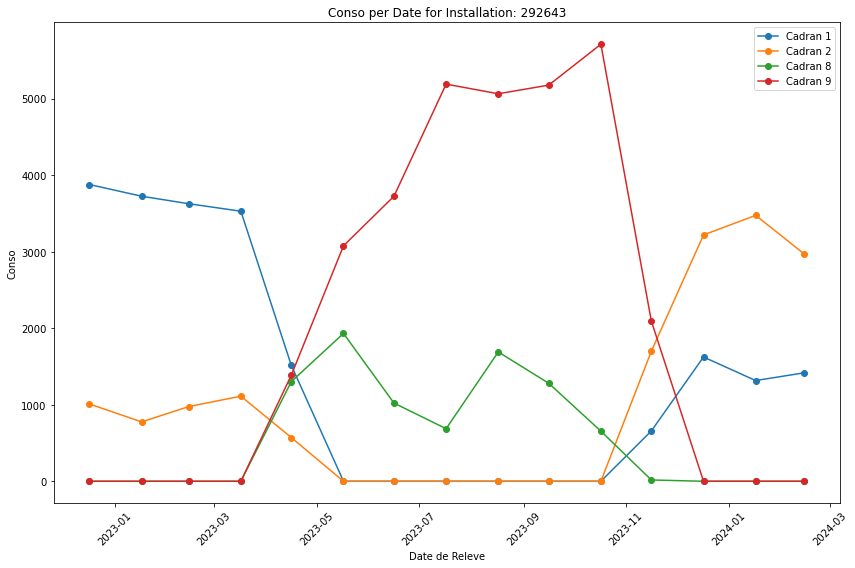

[('8111746', Timestamp('2023-12-07 00:00:00'), 5)]


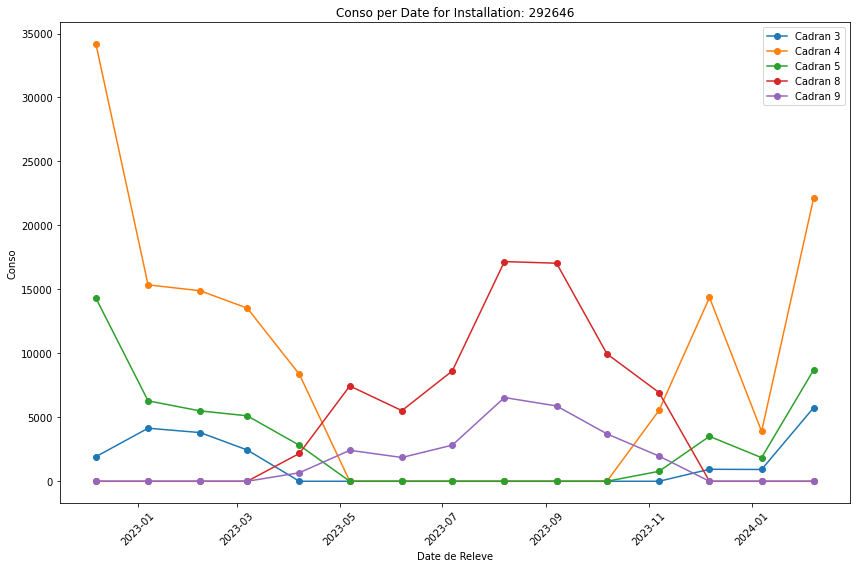

[('7810708', Timestamp('2023-05-13 00:00:00'), 8)]


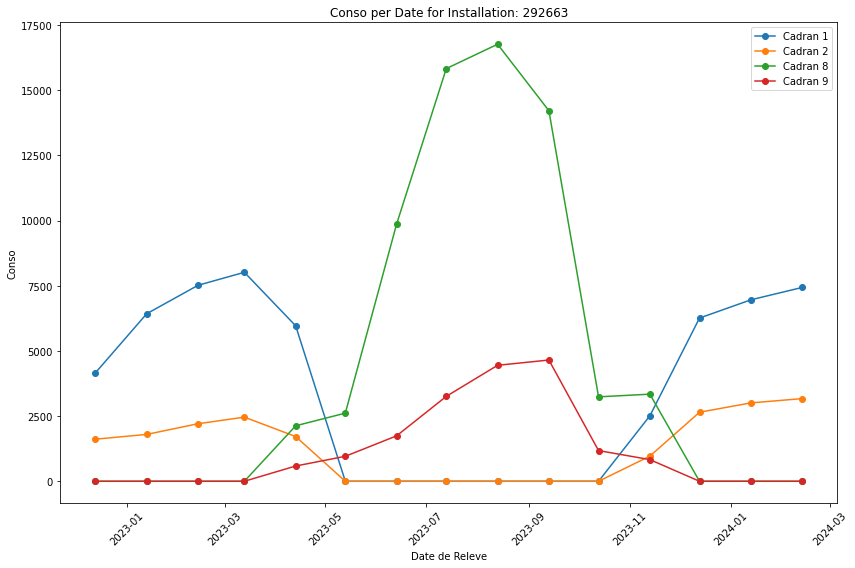

[('8253027', Timestamp('2024-02-13 00:00:00'), 1)]


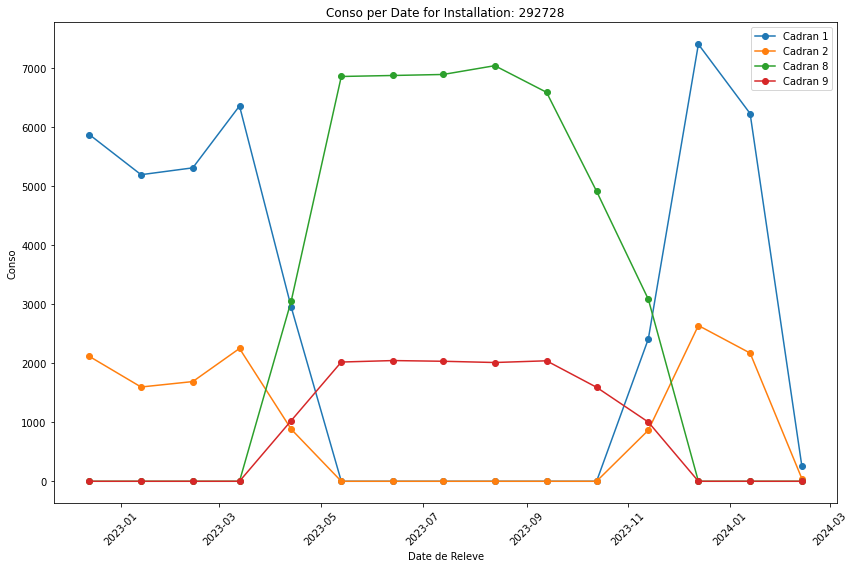

[('7665838', Timestamp('2023-01-31 00:00:00'), 1)]


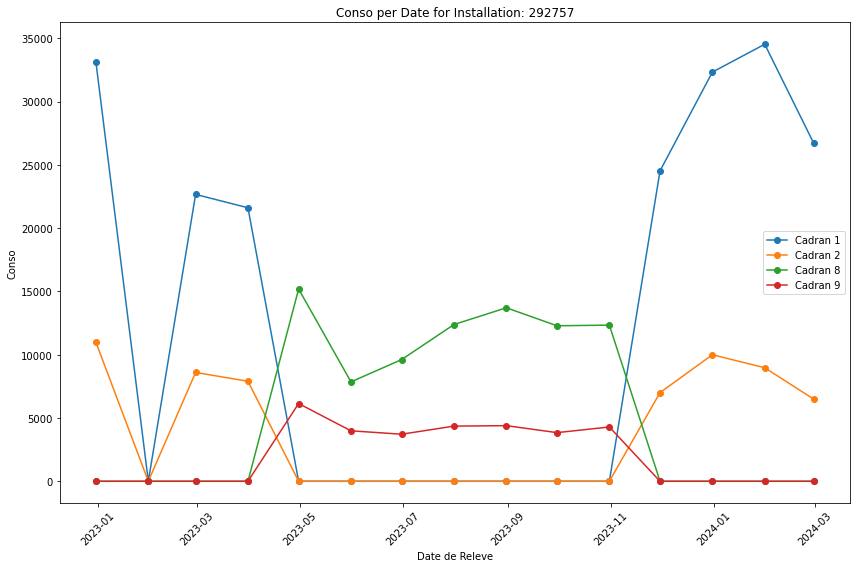

[('7816963', Timestamp('2023-05-19 00:00:00'), 8), ('7860441', Timestamp('2023-06-18 00:00:00'), 8), ('7904250', Timestamp('2023-07-19 00:00:00'), 8), ('7946883', Timestamp('2023-08-19 00:00:00'), 8), ('7989763', Timestamp('2023-09-18 00:00:00'), 8), ('8032325', Timestamp('2023-10-19 00:00:00'), 8)]


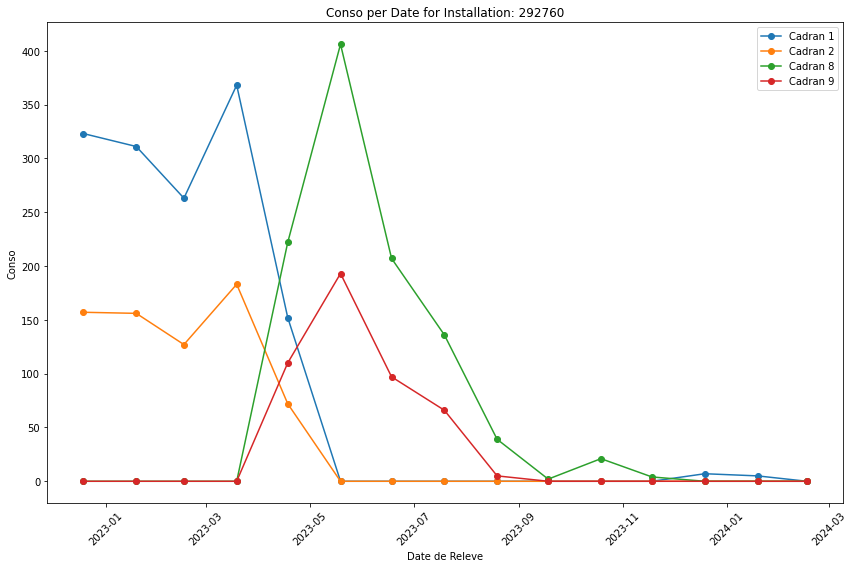

In [30]:
consolidated_df = releves_df

show_describe= False
need_sorting = False
check_matching = True

if ENV.should_rename_columns:
  consolidated_df.rename(columns=transform_column_name, inplace=True)
  ENV.target_column_name = ENV.target_column_name.upper()

if show_describe:
    print('This is the Shape of the data')
    print('='*49)
    print("The total number of columns: ", consolidated_df.shape[1])
    print("The total number of rows: ", consolidated_df.shape[0])
    print('='*49)

    print('\nTypes of the Dataset:')
    print("=" * 40)
    print(consolidated_df.dtypes)

    print('\nDescription of the numerical Dataset:')
    print("=" * 40)
    numerical_description = consolidated_df.describe(include=['int', 'float']).T
    print(numerical_description)

    print('\nDescription of the Categorical Dataset:')
    print("=" * 40)
    #categorical_description = df.describe(include=['object', 'bool']).T
    #categorical_description = df.describe(include='all').T
    categorical_description = consolidated_df.describe(include=['object', 'bool']).T
    print(categorical_description)

    print('\nDescription of the nb values:')
    print("=" * 40)
    value_counts_per_column = consolidated_df.nunique()

    # Convert the Series to a DataFrame for better table display
    value_counts_df = value_counts_per_column.reset_index()
    print(value_counts_df)
    
    print('\nDescription of the missing values:')
    print("=" * 40)
    value_counts_per_column = consolidated_df.isna().sum()
    # Convert the Series to a DataFrame for better table display
    value_counts_df = value_counts_per_column.reset_index()
    print(value_counts_df)

    # Define a styling function
    def style_description(s):
        return f'background-color: lightblue; font-weight: bold;'

    # Apply the styling to the DataFrame
    styled_description = categorical_description.style.applymap(style_description)
    styled_description
    #print(styled_description)

    print("\nis null")
    print("=" * 40)
    print(consolidated_df.isnull().sum())

    print("\nhead")
    print("=" * 40)
    consolidated_df.head()


if False:
    print("=" * 40)
    print("One to One correspondances")
    print("=" * 40)
    appareil_equipement =consolidated_df.drop_duplicates(subset=['Appareil', 'Equipement'])
    appareil_to_equipement_unique = appareil_equipement.groupby('Appareil').size().max() > 1
    print(f"Can appareil be linked to more than one Equipement: {appareil_to_equipement_unique}")
    equipement_to_appareil_unique = appareil_equipement.groupby('Equipement').size().max() > 1
    print(f"Can Equipement be linked to more than one appareil: {equipement_to_appareil_unique}")

    installation_equipement =consolidated_df.drop_duplicates(subset=['Installation', 'Equipement'])
    installation_to_equipement_unique = installation_equipement.groupby('Equipement').size().max() > 1
    print(f"Can Equipement be linked to more than one Installation: {installation_to_equipement_unique}")
    equipement_to_installation_unique = installation_equipement.groupby('Installation').size().max() > 1
    print(f"Can Installation be linked to more than one Equipement: {equipement_to_installation_unique}")

    installation_appareil =consolidated_df.drop_duplicates(subset=['Installation', 'Appareil'])
    installation_to_appareil_unique = installation_appareil.groupby('Appareil').size().max() > 1
    print(f"Can Appareil be linked to more than one Installation: {installation_to_appareil_unique}")
    appareil_to_installation_unique = installation_appareil.groupby('Installation').size().max() > 1
    print(f"Can Installation be linked to more than one Appareil: {appareil_to_installation_unique}")

    print("Finally : an Installation has one to many with Appareil and Equipement")
    print("But many to many Installation=Appareil ?")

    
def get_unmatched_anomalie_ids(anomalies_df, consolidated_df,nb_rows,verbose=False):
    if verbose:
        print("=" * 40)
        print("Check Releves matching")
        print("=" * 40)

    first_anomalies_values = anomalies_df
    nb_lines= min(nb_rows,len(anomalies_df))
    if nb_lines>0:
        first_anomalies_values = anomalies_df.head(nb_rows)
    else:
        nb_lines=len(anomalies_df)

    count=0
    installation_anomalies={}
    not_found_ids=[]
    for index, ano in first_anomalies_values.iterrows():
        ano_releve_id=ano['Releve']
        match = consolidated_df.loc[consolidated_df['Releve'] == ano_releve_id]
        if not match.empty:#found in releves
            count+=1
            #print(match)            
        else:
            releve_id= str(ano['Releve'])
            not_found_id = str(ano['Num_ano'])
            not_found_ids.append(not_found_id)
            ano_date = ano['Date_de_anomalie']
            ''' Prm does not match Installation
            installation = ano['Installation']
            if installation in installation_anomalies.keys():
                installation_anomalies[installation].append(ano_releve_id)
            else:
                installation_anomalies[installation]=[ano_releve_id]
            '''
            if verbose:
                print(f'Anomalie Releve not found in releves references :{releve_id} from {not_found_id} with date {ano_date}')
    if verbose:
        print(f"nb Found Anomalie releves in {nb_lines} releves: {count}")
    return not_found_ids,installation_anomalies
    
if check_matching:
    get_unmatched_anomalie_ids(anomalies_df, consolidated_df,100, True)

    print("removing first occurence of Date_de_releve")
    if need_sorting:
        df_sorted = consolidated_df.sort_values(by=['Installation', 'Cadran_key', 'Date_de_releve'])
    else:
        df_sorted = consolidated_df
    df_filtered_no_first_releve = df_sorted[df_sorted.groupby(['Cadran_key']).cumcount() > 0]
    
    nb_checks=100
    print(f"And I check again against {nb_checks} first anomalies")
    not_found_ano_ids,installation_anomalies= get_unmatched_anomalie_ids(anomalies_df, df_filtered_no_first_releve,nb_checks, True)
    nb_not_found = len(not_found_ano_ids)
    nb_anomalies = len(anomalies_df)
    if nb_checks>0:
        nb_anomalies=min(nb_anomalies,nb_checks)
    print(f'nb anomalies not found {nb_not_found} in {nb_anomalies} after removing first occurence of Date_de_releve in releves ')

    print (not_found_ano_ids)
    installations_in_anomalies={}
    anomalies_df_head= anomalies_df.head(nb_checks)
    for index, row in anomalies_df_head.iterrows():
        ano_id=str(row['Num_ano'])
        releve_id=row['Releve']
        if ano_id not in not_found_ano_ids:
            infos = get_releve_info(df_sorted,releve_id)
            installation= infos['Installation'].iloc[0]
            if installation not in installations_in_anomalies.keys():
                installations_in_anomalies[installation]=[]
            releve_id = row['Releve']
            ano_releve_date = row['Date_de_releve']
            ano_cadran=row['Cadran']
            installations_in_anomalies[installation].append((ano_id,ano_releve_date,ano_cadran))
    
    print("*"*20)
    print("Installation graphs")
    print("*"*20)
    max_nb_graphs=10
    index=0
    for installation, value in installations_in_anomalies.items():
        index+=1
        if index>max_nb_graphs:
            break
        print(value)
        plot_value_per_date_for_installation(df_filtered_no_first_releve,installation,'Conso')
        





# Analysis

In [ ]:
def manage_missing_values(df):
    column_name= "Puissance_souscrite"
    #debugging purposes 
    debug = df[df['Puissance_souscrite'].isna()].head(2)
    print(debug)
    
    na_counts_before = df[column_name].isna().sum()
    df = df.dropna(subset=[column_name])
    na_counts_afer = df[column_name].isna().sum()
    nb_dropepd = na_counts_before - na_counts_afer
    print(f"manage_missing_values, dropped {nb_dropepd}")
    return df

In [41]:
from sklearn.ensemble import IsolationForest

if 'anomalies_df' not in locals():
    anomalies_df = get_anomalies()

consolidated_with_changes=None
if 'consolidated_with_changes' not in locals() or consolidated_with_changes is None:
    consolidated_with_changes=get_aggregated_data_with_Adjusted_Index_Change()
    try:
        consolidated_with_changes['Date_de_releve']=pd.to_datetime(consolidated_with_changes['Date_de_releve'], format='%Y%m%d')
    except:
        consolidated_with_changes['Date_de_releve']=pd.to_datetime(consolidated_with_changes['Date_de_releve'], format='%Y-%m-%d')
    consolidated_with_changes['month']=consolidated_with_changes['Date_de_releve'].dt.month
    consolidated_with_changes = consolidated_with_changes.dropna(subset=['Index_change'])# because we drop first if we want the diff...
print("*"*20)


nb_releves = len(consolidated_with_changes)
nb_anomalies = len(anomalies_df)
print(f'Nb anomalies {nb_anomalies} out of {nb_releves} releves')

estimated_percent_real_ano = 48.0/323.0 # from supervised

#let's consider only when getting down
significant_down_changes = consolidated_with_changes[(consolidated_with_changes['Index_pct_change'] < -25)&(consolidated_with_changes['Index_change'] < -3000) & (~consolidated_with_changes['Time_diff'].isna())]

nb_significant_down_changes= len(significant_down_changes)


contamination = nb_anomalies/nb_significant_down_changes *estimated_percent_real_ano

print(f'Estimated contamination {contamination} ')

significant_down_changes['Type_cadran']=consolidated_with_changes['Type_cadran'].astype(str)
significant_down_changes['Reduced_Naf']=consolidated_with_changes['Code_Naf'].astype(str).str[:3]
# we take a subset to ignore some columns
columns_to_keep=['Releve','Région','Type_cadran','Index_change','month','Reduced_Naf','Puissance_souscrite']

subset_df = None

if subset_df is None:
    print("regenerating subset")
    subset_df=significant_down_changes[columns_to_keep]
    print(subset_df.dtypes)
    subset_df = subset_df.copy()
    normalize(subset_df,'Puissance_souscrite',12)
    normalize(subset_df,'Index_change',12)
    encode_columns(subset_df)
columns_to_drop=['']

print(subset_df.head(2))

print("Unique values")
print(subset_df.describe())

#Isolation forest
clf = IsolationForest(n_estimators=100, contamination=contamination, random_state=42)
print("Starting Isolation forest on following columns")
print(subset_df.columns)
clf.fit(subset_df)
print("fitted")

predictions = clf.predict(subset_df)
print("predicted")
subset_df['anomaly'] = predictions

# Filter outliers
outliers = subset_df[subset_df['anomaly'] == -1]
print(outliers[:10])
    


get_aggregated_data_with_Adjusted_Index_Change
/Users/michaelargi/projects/perso/unsupervised/ML_Export_20_03/consolidated_with_Adjusted_Index_Change.csv
********************
Nb anomalies 32369 out of 8663127 releves
Estimated contamination 0.3389651095743105 


/var/folders/7v/cgc6db_s0jg20l4ckkkc8s7w0000gn/T/ipykernel_51400/2072490658.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  significant_down_changes['Type_cadran']=consolidated_with_changes['Type_cadran'].astype(str)
/var/folders/7v/cgc6db_s0jg20l4ckkkc8s7w0000gn/T/ipykernel_51400/2072490658.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  significant_down_changes['Reduced_Naf']=consolidated_with_changes['Code_Naf'].astype(str).str[:3]
/Users/michaelargi/opt/anaconda3/lib/python3.9/site-packages/sk

regenerating subset
Releve                   int64
Région                  object
Type_cadran             object
Index_change           float64
month                    int64
Reduced_Naf             object
Puissance_souscrite    float64
dtype: object
          Releve  Région  Type_cadran  Index_change  month  Reduced_Naf  \
230   3839304636      58            5         11.97      2          122   
9601  3931776760      75            5         11.98      4          107   

      Puissance_souscrite  
230                  0.10  
9601                 0.08  
NA counts
Releve                 0
Région                 0
Type_cadran            0
Index_change           0
month                  0
Reduced_Naf            0
Puissance_souscrite    0
dtype: int64
Unique values
Releve                 14191
Région                   119
Type_cadran               13
Index_change           14038
month                     12
Reduced_Naf              217
Puissance_souscrite     1953
dtype: int64
Starting Is

********************
Installation graphs
********************
[(2334658   2022-11-21
Name: Date_de_releve, dtype: datetime64[ns], 2334658    1
Name: Cadran, dtype: int64), (2334659   2022-11-21
Name: Date_de_releve, dtype: datetime64[ns], 2334659    2
Name: Cadran, dtype: int64), (2334660   2022-11-21
Name: Date_de_releve, dtype: datetime64[ns], 2334660    8
Name: Cadran, dtype: int64), (2334661   2022-11-21
Name: Date_de_releve, dtype: datetime64[ns], 2334661    9
Name: Cadran, dtype: int64)]


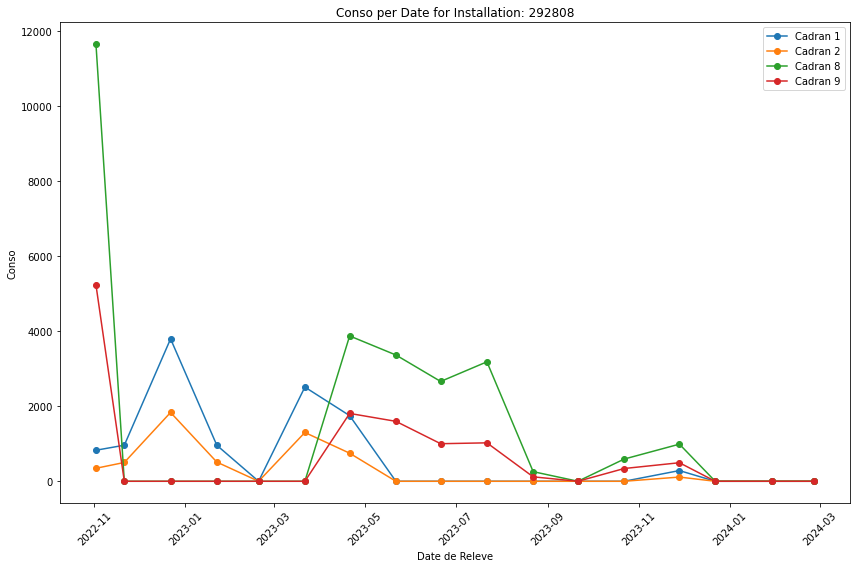

[(6334969   2023-12-17
Name: Date_de_releve, dtype: datetime64[ns], 6334969    9
Name: Cadran, dtype: int64)]


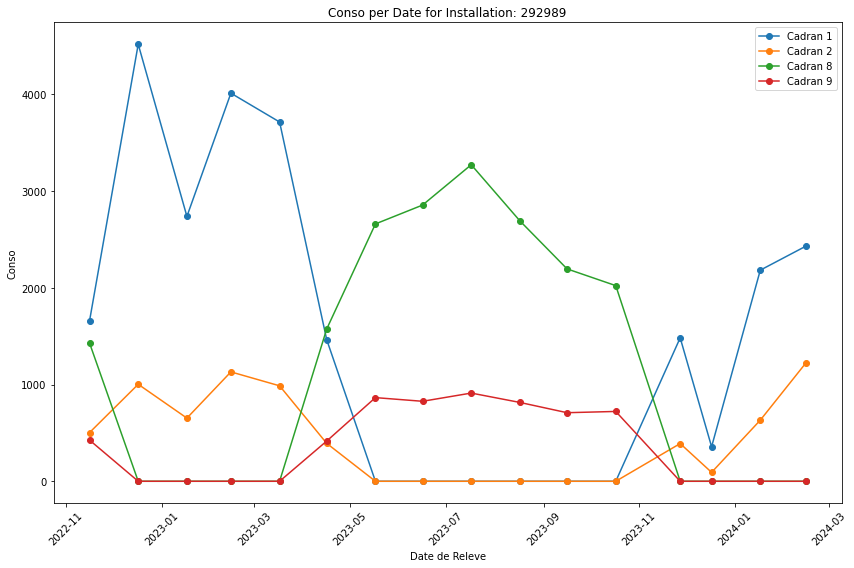

[(5174553   2023-02-08
Name: Date_de_releve, dtype: datetime64[ns], 5174553    9
Name: Cadran, dtype: int64)]


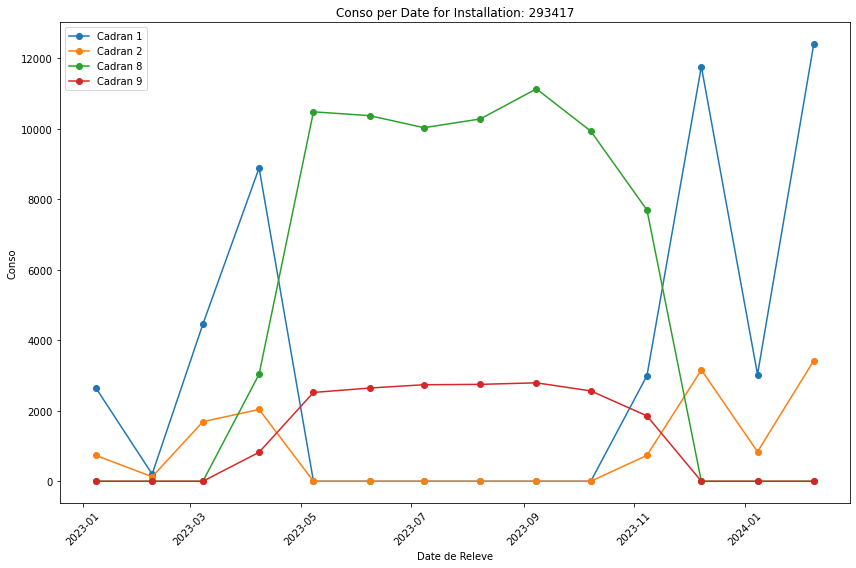

[(1038955   2024-01-17
Name: Date_de_releve, dtype: datetime64[ns], 1038955    8
Name: Cadran, dtype: int64), (1038956   2024-01-17
Name: Date_de_releve, dtype: datetime64[ns], 1038956    9
Name: Cadran, dtype: int64)]


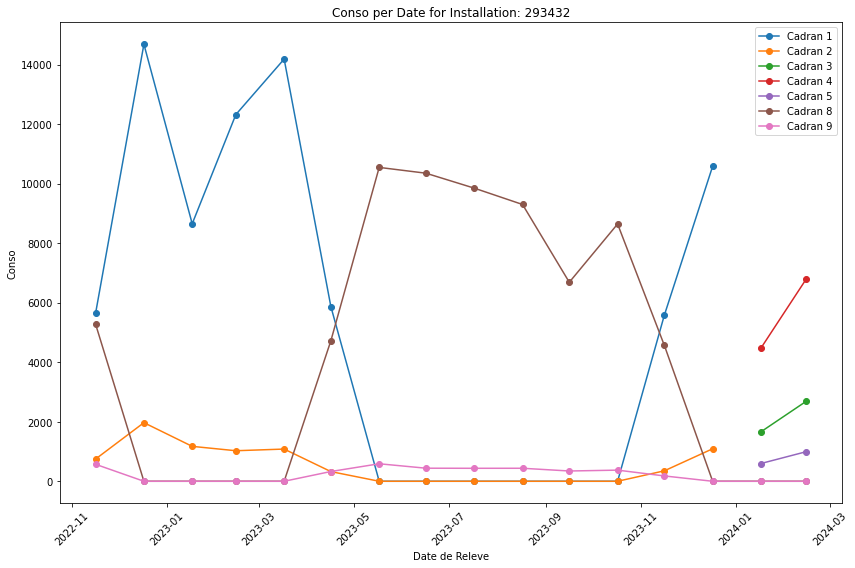

[(6294395   2023-12-10
Name: Date_de_releve, dtype: datetime64[ns], 6294395    9
Name: Cadran, dtype: int64)]


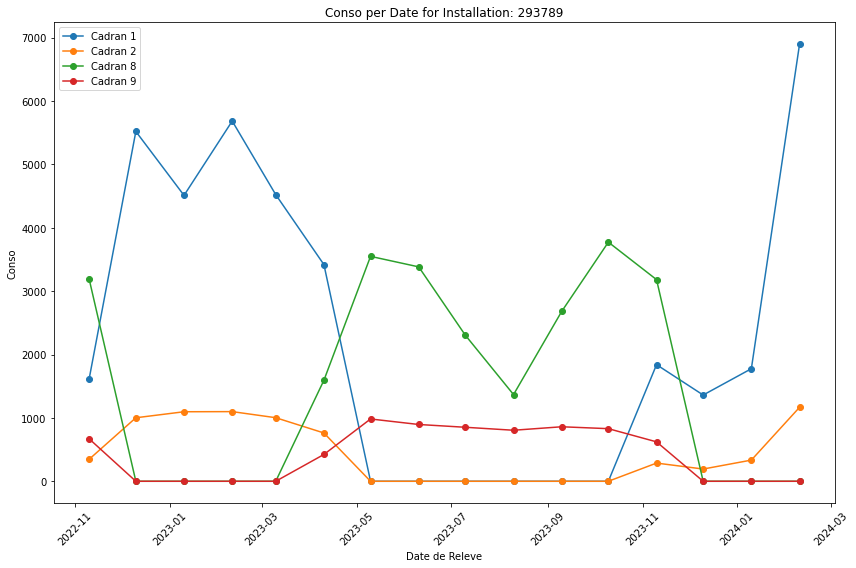

[(3338635   2022-12-24
Name: Date_de_releve, dtype: datetime64[ns], 3338635    8
Name: Cadran, dtype: int64)]


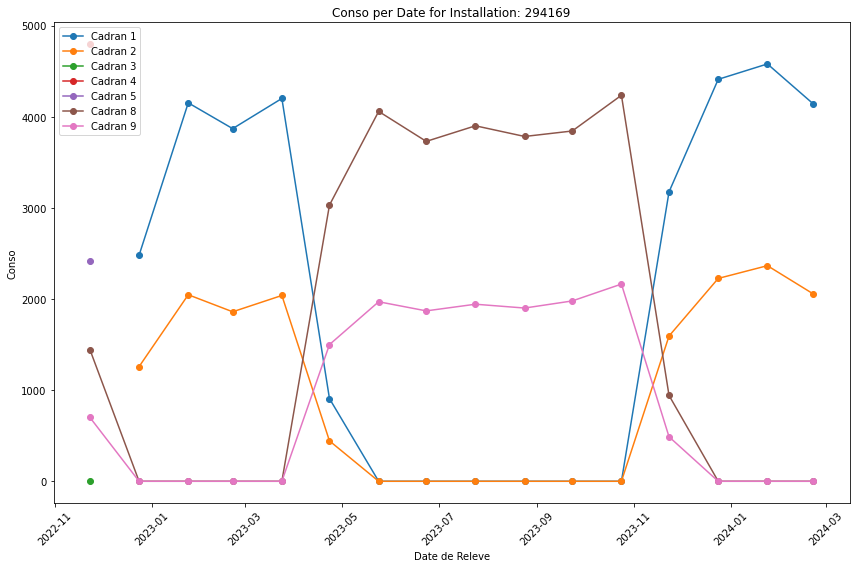

[(9136777   2023-10-15
Name: Date_de_releve, dtype: datetime64[ns], 9136777    8
Name: Cadran, dtype: int64), (9136778   2023-10-15
Name: Date_de_releve, dtype: datetime64[ns], 9136778    9
Name: Cadran, dtype: int64)]


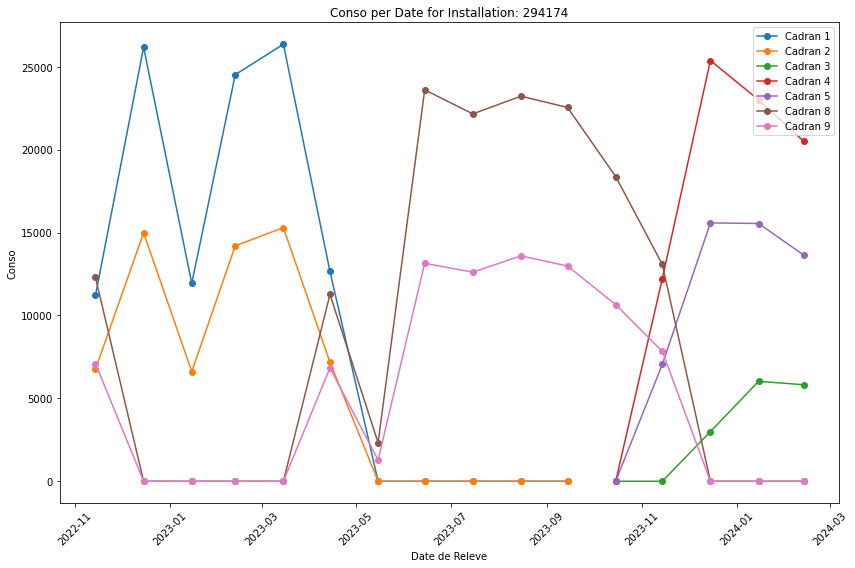

[(5797929   2023-12-08
Name: Date_de_releve, dtype: datetime64[ns], 5797929    2
Name: Cadran, dtype: int64), (5797931   2023-12-08
Name: Date_de_releve, dtype: datetime64[ns], 5797931    9
Name: Cadran, dtype: int64)]


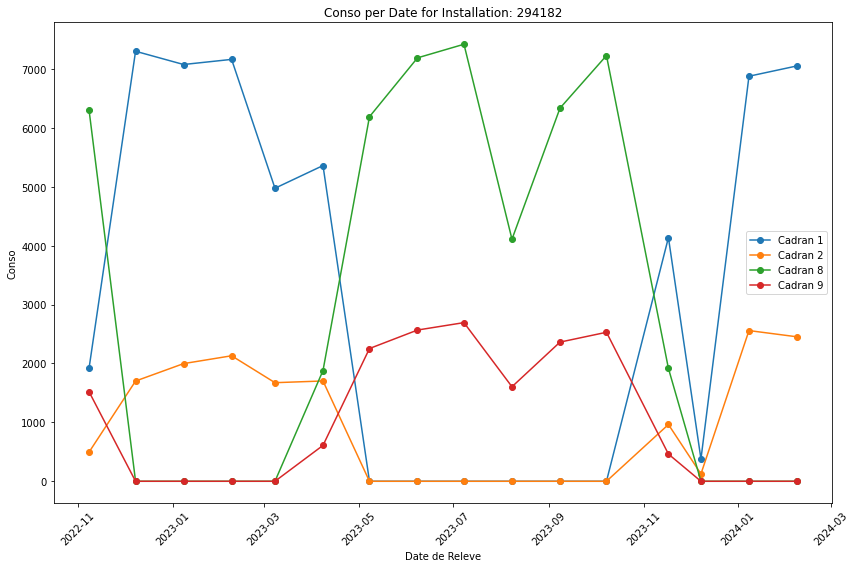

[(1759586   2024-02-19
Name: Date_de_releve, dtype: datetime64[ns], 1759586    9
Name: Cadran, dtype: int64)]


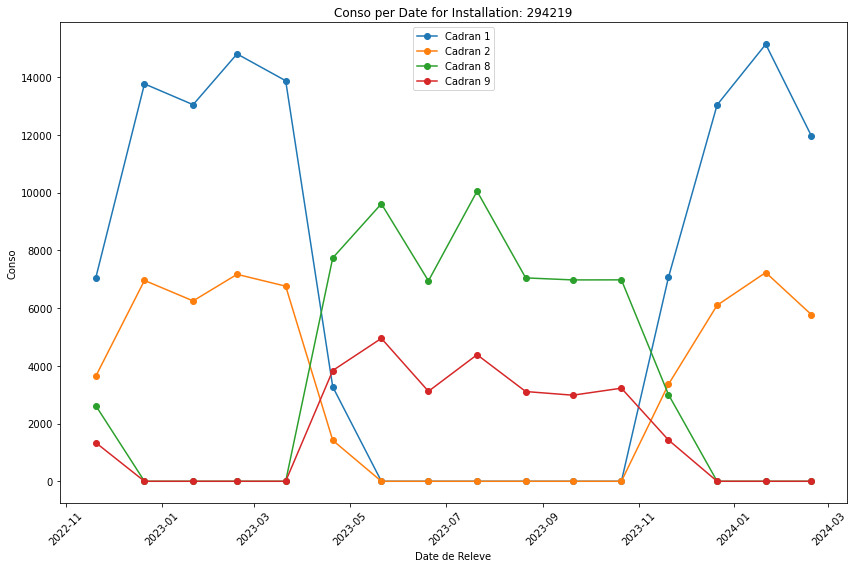

[(1767363   2024-02-10
Name: Date_de_releve, dtype: datetime64[ns], 1767363    9
Name: Cadran, dtype: int64)]


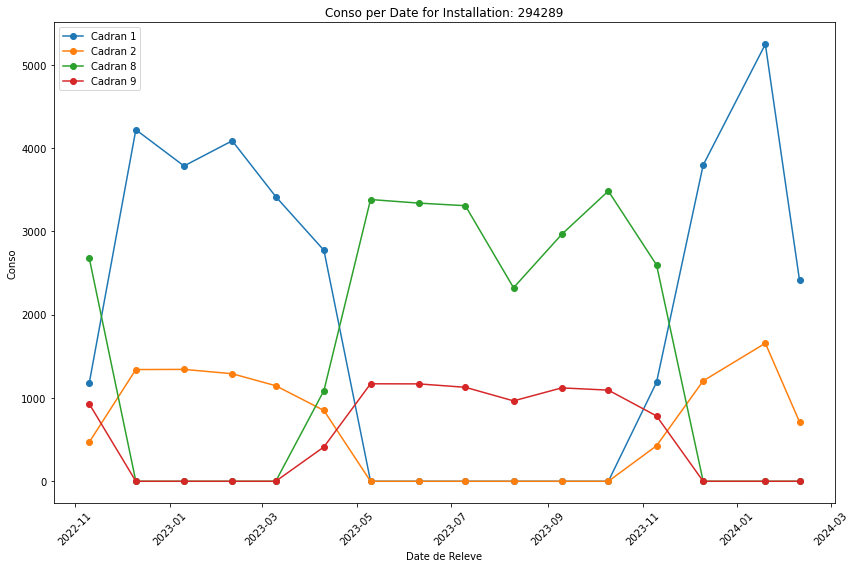

'\n#significant_changes = consolidated_with_changes[(consolidated_with_changes[\'Adjusted_Index_Change\'] < -1) & (~consolidated_with_changes[\'Time_diff\'].isna())]\n\nsignificant_changes = consolidated_with_changes[(consolidated_with_changes[\'Index_pct_change\'] < -25)&(consolidated_with_changes[\'Index_change\'] < -3000) & (~consolidated_with_changes[\'Time_diff\'].isna())]\n\nprint(f\'Nb significant_changes:{len(significant_changes)}\')\n\nadded_installations=[]\nmax_nb= 10\nnb = 0\n\nfor index, row in significant_changes.iterrows():\n    if nb>max_nb:\n        break\n    \n    # Access the Releve and Cadran_key values for the current row\n    releve_value = int(row[\'Releve\'])\n    cadran_key_value = row[\'Cadran_key\']\n    installation_value = row[\'Installation\']\n    if installation_value in added_installations:\n        continue\n    nb+=1\n    added_installations.append(installation_value)\n    print(f\' Releve {releve_value} and Cadran {cadran_key_value} and Installation

In [42]:
#dataframe_to_csv(outliers,"likely_anomalies.csv")
extract = outliers[:10]
releves_df = get_combined_df()
installations_in_anomalies={}
for index, row in outliers.iterrows():
    releve_id=row['Releve']
    infos = get_releve_info(releves_df,releve_id)
    installation= infos['Installation'].iloc[0]
    releve_date = infos['Date_de_releve']
    cadran=infos['Cadran']
    if installation not in installations_in_anomalies.keys():
        installations_in_anomalies[installation]=[]
    installations_in_anomalies[installation].append((releve_date,cadran))

print("*"*20)
print("Installation graphs")
print("*"*20)
max_nb_graphs=10
index=0
for installation, value in installations_in_anomalies.items():
    index+=1
    if index>max_nb_graphs:
        break
    print(value)
    plot_value_per_date_for_installation(releves_df,installation,'Conso')
        




'''
#significant_changes = consolidated_with_changes[(consolidated_with_changes['Adjusted_Index_Change'] < -1) & (~consolidated_with_changes['Time_diff'].isna())]

significant_changes = consolidated_with_changes[(consolidated_with_changes['Index_pct_change'] < -25)&(consolidated_with_changes['Index_change'] < -3000) & (~consolidated_with_changes['Time_diff'].isna())]

print(f'Nb significant_changes:{len(significant_changes)}')

added_installations=[]
max_nb= 10
nb = 0

for index, row in significant_changes.iterrows():
    if nb>max_nb:
        break
    
    # Access the Releve and Cadran_key values for the current row
    releve_value = int(row['Releve'])
    cadran_key_value = row['Cadran_key']
    installation_value = row['Installation']
    if installation_value in added_installations:
        continue
    nb+=1
    added_installations.append(installation_value)
    print(f' Releve {releve_value} and Cadran {cadran_key_value} and Installation {installation_value}')
    #plot_index_per_date_for_Cadran(consolidated_df,cadran_key_value)
    plot_index_per_date_for_installation(consolidated_df, installation_value)
    infos = get_releve_info(significant_changes,releve_value).to_string()
    print("*"*30)
    print(infos)
    print("-"*30)

found_anomalies=[]
for index, row in significant_changes.iterrows():
    releve_value = int(row['Releve'])
    infos = get_releve_info(anomalies_df,releve_value)
    if len(infos)>0:
        found_anomalies.append(releve_value)
        #print(infos)
filtered_df = anomalies_df[anomalies_df['Releve'].isin(found_anomalies)]

dataframe_to_csv(filtered_df,"found_anomalies.csv")
print("done")
'''

In [33]:
'''
5520Z: Hébergement touristique et autre hébergement de courte durée
'''

#Manual checks
'''
releve = 3887112992
infos = get_releve_info(significant_changes,releve)
print(infos)
Installation= infos['Installation'].iloc[0]
print(f'Installation {Installation}')
infos_ano = get_releve_info(anomalies_df,releve)
print(infos_ano)
'''

'''
head=filtered_df.head()
for index, row in filtered_df.iterrows():
    releve_value = int(row['Releve'])
    print(releve_value)
    infos = get_releve_info(significant_changes,releve_value)
    installation= infos['Installation'].iloc[0]
    plot_index_per_date_for_installation(consolidated_df, installation, f'installation_cadrans/{installation}.jpg')
'''

'''



infos = get_releve_info(significant_changes,3887112991)
print(infos)
infos = get_releve_info(significant_changes,3887112992)
print(infos)

Code_Naf = infos['Code_Naf'].iloc[0]
installation= infos['Installation'].iloc[0]
print(f'Installation {Installation}')
plot_index_per_date_for_installation(consolidated_df, installation)

print(len(filtered_df))
print(len(anomalies_df))

print("done")
'''


'\n\n\n\ninfos = get_releve_info(significant_changes,3887112991)\nprint(infos)\ninfos = get_releve_info(significant_changes,3887112992)\nprint(infos)\n\nCode_Naf = infos[\'Code_Naf\'].iloc[0]\ninstallation= infos[\'Installation\'].iloc[0]\nprint(f\'Installation {Installation}\')\nplot_index_per_date_for_installation(consolidated_df, installation)\n\nprint(len(filtered_df))\nprint(len(anomalies_df))\n\nprint("done")\n'

In [34]:
# list appareil with average consumption >100 kwh
'''
minaverage=100
aggregated_data_minimal = consolidated_df.groupby(['Appareil', 'Date_de_releve'], as_index=False)['Index'].sum().rename(columns={'Index': 'Aggregated_Index'})

# Step 2: Calculate the average Aggregated_Index for each Appareil
average_agg_index = aggregated_data_minimal.groupby('Appareil', as_index=False)['Aggregated_Index'].mean().rename(columns={'Aggregated_Index': 'Average_Aggregated_Index'})

# Filter out Appareils with an average Aggregated_Index below 100
filtered_appareils = average_agg_index[average_agg_index['Average_Aggregated_Index'] >= minaverage]
print(f"Nb filtered appareilsl: {len(filtered_appareils)}")

aggregated_data = consolidated_df[consolidated_df['Appareil'].isin(filtered_appareils['Appareil'])]


aggregated_data = aggregated_data.groupby(['Appareil', 'Date_de_releve'])['Index'].sum().reset_index(name='Aggregated_Index')

aggregated_data.sort_values(by=['Appareil', 'Date_de_releve'], inplace=True)

# Calculate the difference in days between successive Date_de_releve entries
aggregated_data['Time_diff'] = aggregated_data.groupby('Appareil')['Date_de_releve'].diff().dt.days

# Calculate the percentage change of the Index
print(aggregated_data.columns)
aggregated_data['Index_pct_change'] = aggregated_data.groupby('Appareil')['Aggregated_Index'].pct_change() * 100

# Adjust the Index Percentage Change by the Time Difference
aggregated_data['Adjusted_Index_Change'] = aggregated_data['Index_pct_change'] / aggregated_data['Time_diff']

# Filter for significant changes, adjust criteria as needed
significant_changes_per_apparel = aggregated_data[(aggregated_data['Index_pct_change'].abs() > 20) & (~aggregated_data['Time_diff'].isna())]

unique_appareils = significant_changes_per_apparel['Appareil'].unique()
print(f"Nb significant changes in Appareil: {len(unique_appareils)}")
'''

'\nminaverage=100\naggregated_data_minimal = consolidated_df.groupby([\'Appareil\', \'Date_de_releve\'], as_index=False)[\'Index\'].sum().rename(columns={\'Index\': \'Aggregated_Index\'})\n\n# Step 2: Calculate the average Aggregated_Index for each Appareil\naverage_agg_index = aggregated_data_minimal.groupby(\'Appareil\', as_index=False)[\'Aggregated_Index\'].mean().rename(columns={\'Aggregated_Index\': \'Average_Aggregated_Index\'})\n\n# Filter out Appareils with an average Aggregated_Index below 100\nfiltered_appareils = average_agg_index[average_agg_index[\'Average_Aggregated_Index\'] >= minaverage]\nprint(f"Nb filtered appareilsl: {len(filtered_appareils)}")\n\naggregated_data = consolidated_df[consolidated_df[\'Appareil\'].isin(filtered_appareils[\'Appareil\'])]\n\n\naggregated_data = aggregated_data.groupby([\'Appareil\', \'Date_de_releve\'])[\'Index\'].sum().reset_index(name=\'Aggregated_Index\')\n\naggregated_data.sort_values(by=[\'Appareil\', \'Date_de_releve\'], inplace=True

In [35]:
'''
print(unique_appareils[:10])
plot_index_per_date_for_appareil(consolidated_df,10000000017  )
'''

'\nprint(unique_appareils[:10])\nplot_index_per_date_for_appareil(consolidated_df,10000000017  )\n'

In [36]:
'''
df = consolidated_df
df.sort_values(by=['Appareil', 'Cadran', 'Date_de_releve'], inplace=True)

df['Index_pct_change'] = df.groupby(['Appareil', 'Cadran'])['Index'].pct_change()

# Calculate the mean of percentage changes for each Appareil and Cadran to reduce noise
mean_pct_changes = df.groupby(['Appareil', 'Cadran'])['Index_pct_change'].mean().reset_index()

# Pivot to have each Cadran's mean percentage change as a column
pivot_mean_pct_changes = mean_pct_changes.pivot(index='Appareil', columns='Cadran', values='Index_pct_change')

# Calculate the variance of these mean percentage changes across Cadrans for each Appareil
pivot_mean_pct_changes['variance_across_cadrans'] = pivot_mean_pct_changes.var(axis=1)

# Define a threshold for significant variance
threshold = 0.5  # Adjust this based on your data and requirements

# Find Appareils with variance above the threshold
significant_variance_appareils = pivot_mean_pct_changes[pivot_mean_pct_changes['variance_across_cadrans'] > threshold]
'''

"\ndf = consolidated_df\ndf.sort_values(by=['Appareil', 'Cadran', 'Date_de_releve'], inplace=True)\n\ndf['Index_pct_change'] = df.groupby(['Appareil', 'Cadran'])['Index'].pct_change()\n\n# Calculate the mean of percentage changes for each Appareil and Cadran to reduce noise\nmean_pct_changes = df.groupby(['Appareil', 'Cadran'])['Index_pct_change'].mean().reset_index()\n\n# Pivot to have each Cadran's mean percentage change as a column\npivot_mean_pct_changes = mean_pct_changes.pivot(index='Appareil', columns='Cadran', values='Index_pct_change')\n\n# Calculate the variance of these mean percentage changes across Cadrans for each Appareil\npivot_mean_pct_changes['variance_across_cadrans'] = pivot_mean_pct_changes.var(axis=1)\n\n# Define a threshold for significant variance\nthreshold = 0.5  # Adjust this based on your data and requirements\n\n# Find Appareils with variance above the threshold\nsignificant_variance_appareils = pivot_mean_pct_changes[pivot_mean_pct_changes['variance_across

In [37]:
'''
print(significant_variance_appareils)
'''

'\nprint(significant_variance_appareils)\n'

# Fitting

In [38]:
print (consolidated_df.columns)
print (consolidated_df.head())
consolidated_df['Reduced_Naf'] = consolidated_df['Code_Naf'].astype(str).str[:3]
#consolidated_df['Codepost2'] = consolidated_df['Codepost.'].astype(str).str[:2]
#122
#consolidated_with_changes
#let's extract most common Reduced_Naf and Codepost2

print(consolidated_df.nunique())
region_counts = consolidated_df['Region'].value_counts()
naf_counts = consolidated_df['Reduced_Naf'].value_counts()


most_common_Naf =consolidated_df['Reduced_Naf'].mode()[0]
most_common_Codepost2 =consolidated_df['Region'].mode()[0]


second_most_common_region = region_counts.index[1]
second_most_common_naf = naf_counts.index[1]

print(f'Choosing for test {second_most_common_naf} and {second_most_common_region}')

filtered_df = consolidated_df[(consolidated_df['Reduced_Naf'] == most_common_Naf) & (consolidated_df['Region'] == most_common_Codepost2)]

columns_to_drop=['Appareil', 'Equipement', 'Cadran','Code_Naf', 'Installation']
filtered_df = drop_columns(filtered_df,columns_to_drop)

filtered_df['Index_mean'] = filtered_df.groupby('Cadran_key')['Index'].transform('mean')



filtered_df['Index_normalized'] = filtered_df['Index'] / filtered_df['Index_mean']

filtered_df = filtered_df.dropna(subset=['Index_normalized'])

filtered_df['Mois_de_releve'] = filtered_df['Date_de_releve'].dt.month
filtered_df['Semaine_de_releve'] = filtered_df['Date_de_releve'].dt.week

reference_date = pd.Timestamp('2023-01-01')
filtered_df['DaysSinceReference'] = (filtered_df['Date_de_releve'] - reference_date).dt.days

columns_to_drop=[ 'Date_de_releve']
filtered_df = drop_columns(filtered_df,columns_to_drop)
print(filtered_df.columns)

sorted_df = filtered_df.sort_values(by='DaysSinceReference')
plt.figure(figsize=(10, 6))  # Optional: Adjusts the figure size
plt.plot(sorted_df['DaysSinceReference'], sorted_df['Index_normalized'], marker='o', linestyle='-')
plt.title('Index Mean over Days Since Reference')  # Optional: Adds a title to the plot
plt.xlabel('Days Since Reference')  # Optional: Adds a label to the x-axis
plt.ylabel('Index Normalized')  # Optional: Adds a label to the y-axis
plt.grid(True)  # Optional: Adds a grid for better readability
plt.show()


sorted_df = sorted_df.sort_values(by='Mois_de_releve')
plt.figure(figsize=(10, 6))  # Adjust the figure size as needed
plt.scatter(sorted_df['Mois_de_releve'], sorted_df['Index_normalized'])

plt.title('Index Normalized vs. Month of Record')  # Add a title
plt.xlabel('Month of Record')  # Add an x-label
plt.ylabel('Normalized Index')  # Add a y-label
plt.xticks(range(1, 13), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])  # Optional: Set custom x-axis tick labels

plt.grid(True)  # Add a grid for better readability
plt.show()



Index(['Releve', 'Appareil', 'Equipement', 'Cadran', 'Date_de_releve', 'Index',
       'Unitee', 'Installation', 'Région', 'Code_Naf', 'Puissance_souscrite',
       'ABLESGR', 'Type_cadran', 'Conso', 'Cadran_key', 'Time_diff',
       'Index_change', 'Index_pct_change', 'Adjusted_Index_Change', 'month'],
      dtype='object')
             Releve     Appareil  Equipement  Cadran Date_de_releve   Index  \
2878844  3714275138  41036419437     1533706       1     2022-11-11  271210   
3432982  3755982824  41036419437     1533706       1     2022-12-11  279442   
4011785  3800430457  41036878510     2590908       1     2023-01-11  286790   
5171835  3844798940  41036878510     2590908       1     2023-02-11  287982   
4591248  3886167062  41036878510     2590908       1     2023-03-11  288087   

        Unitee  Installation Région Code_Naf  Puissance_souscrite  ABLESGR  \
2878844    KWH        292561    211    9601B                95.00        1   
3432982    KWH        292561    211    960

KeyError: 'Region'

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import RANSACRegressor
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline

df = sorted_df
# Assuming df is your DataFrame with 'Mois_de_releve' and 'Index_normalized'
X = df[['Semaine_de_releve']]  # Needs to be 2D for sklearn
y = df['Index_normalized']

print(X.shape)
nan_in_X = X.isna().any()
print("NaN values in X:")
print(nan_in_X)

nan_in_y = y.isna().any()
print("\nNaN values in y:", nan_in_y)

rows_with_nan_in_y = y[y.isna()]
print("\nRows with NaN in y:")
print(rows_with_nan_in_y)

degree = 6  # Degree of the polynomial to fit
ransac = make_pipeline(PolynomialFeatures(degree), RANSACRegressor(random_state=42,residual_threshold=0.5))

ransac.fit(X, y)

X_pred = np.linspace(X.min(), X.max(), 300).reshape(-1, 1)  # Generating points to predict and plot
y_pred = ransac.predict(X_pred)

plt.figure(figsize=(10, 6))
plt.scatter(X, y, color='lightblue', label='Data points')
plt.plot(X_pred, y_pred, color='red', label='RANSAC Polynomial fit')
plt.xlabel('Week of Record')
plt.ylabel('Normalized Index')
plt.title('RANSAC Polynomial Fit to Mois_de_releve vs Index_normalized')
plt.legend()
plt.show()

inlier_mask = ransac.named_steps['ransacregressor'].inlier_mask_
# For the X data, assuming it's a DataFrame or 2D numpy array
X_outliers = X[~inlier_mask]
y_outliers = y[~inlier_mask]
ransac.fit(X_outliers, y_outliers)
# Predict with the new model
X_pred = np.linspace(X_outliers.min(), X_outliers.max(), 300).reshape(-1, 1)  # Adjust as necessary
y_pred = ransac.predict(X_pred)

# Plot
plt.figure(figsize=(10, 6))
plt.scatter(X_outliers, y_outliers, color='lightblue', label='Outliers (new data points)')
plt.plot(X_pred, y_pred, color='red', label='RANSAC Polynomial fit')
plt.xlabel('X')
plt.ylabel('y')
plt.title('RANSAC Re-Fit to Outliers')
plt.legend()
plt.show()

inlier_mask = ransac.named_steps['ransacregressor'].inlier_mask_
# For the X data, assuming it's a DataFrame or 2D numpy array
X_outliers_2 = X_outliers[~inlier_mask]
y_outliers_2 = y_outliers[~inlier_mask]
ransac.fit(X_outliers_2, y_outliers_2)
# Predict with the new model
X_pred = np.linspace(X_outliers_2.min(), X_outliers_2.max(), 300).reshape(-1, 1)  # Adjust as necessary
y_pred = ransac.predict(X_pred)

# Plot
plt.figure(figsize=(10, 6))
plt.scatter(X_outliers_2, y_outliers_2, color='lightblue', label='Outliers (new data points)')
plt.plot(X_pred, y_pred, color='red', label='RANSAC Polynomial fit')
plt.xlabel('X')
plt.ylabel('y')
plt.title('RANSAC Re-Fit to Outliers')
plt.legend()
plt.show()



# Utils to draw some graphs

In [ ]:
#many graphs
def draw_categorical_plot(data, figsize=(8, 6), colors=None):
    if not isinstance(data, pd.Series):
        print(data.name+":ignoring because not a categorical data")
        return
        #raise ValueError("Input data should be a categorical data.")

    # Count the occurrences of each category in the data
    nb_unique_values = data.nunique()

    if nb_unique_values>100 and  nb_unique_values/data.count()>0.7:
      print(data.name+":looks like a key, returning")
      return

    if(nb_unique_values>ENV.nb_binning_limit):
      print(data.name+":too many unique values, binning")
      plt.figure(figsize=(10, 6))
      sns.histplot(data, bins=ENV.nb_binning_limit, kde=False)

      plt.title('Histogram of '+data.name+' with '+str(ENV.nb_binning_limit)+' Bins')
      plt.xlabel(data.name)
      plt.ylabel('Frequency')

      plt.show()
      return

    counts = data.value_counts()

    # Create a figure and axes
    fig, ax = plt.subplots(figsize=figsize)

    # If there are less than 6 unique observations, draw a pie chart
    if len(counts) <= 5:
        counts.plot(kind='pie', autopct='%1.1f%%', colors=colors, ax=ax)
        ax.set_title("Pie Chart of " + data.name)
        ax.set_ylabel("")  # This is to remove the column name from the side of the pie chart
    else:
        # Otherwise, draw a bar chart
        sns.barplot(x=counts.index, y=counts.values, palette=colors, ax=ax)
        ax.set_title("Bar Chart of " + data.name)
        ax.set_ylabel("Count")

    plt.tight_layout()
    plt.show()  # Display the plot

    
if ENV.show_graphs:
  for column in consolidated_df.columns:
    draw_categorical_plot(consolidated_df[column])

#columns_to_consider=df.columns#['HomePlanet','Destination','CryoSleep','VIP','Age','RoomService','FoodCourt','ShoppingMall','Spa','Transported']
